In [1]:
# !pip install scipy
# !pip install geopandas
# !pip install imageio

import pandas as pd
import pickle
import json
import requests
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from scipy import signal
from datetime import date,timedelta
import yaml
import os
import copy
import numpy as np
from itertools import zip_longest
import geopandas as gpd
from shapely.geometry import Polygon
import imageio

from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

cmap = plt.cm.YlOrRd.copy()
cmap.set_bad('lightgrey',1.)

ModuleNotFoundError: No module named 'geopandas'

In [2]:
# shell download and unzip
!rm -rf cb_2018_us_state_500k
!curl https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip > ./cb_2018_us_state_500k.zip
!mkdir cb_2018_us_state_500k && cd cb_2018_us_state_500k && unzip ../cb_2018_us_state_500k.zip

gdf0 = gpd.read_file('./cb_2018_us_state_500k')
territories = ['MP','VI','GU','AS','PR','DC']
gdf0 = gdf0[~gdf0.STUSPS.isin(territories)]
states = gdf0.STUSPS

state_to_abbrev_d = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY", "District of Columbia": "DC", "American Samoa": "AS", "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR", "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI"}
def state_to_abbrev(x):
    return state_to_abbrev_d[x] if x in state_to_abbrev_d else '??'

def USmap(data, scalarcmap=None):
    if scalarcmap is None:
        scalarcmap = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.LogNorm(vmin=1e-2, vmax=10, clip=True))
    gdf = gdf0.merge(data.rename('data'), on='STUSPS', how='left').fillna(0.)
    gdf['value_determined_color'] = gdf['data'].apply(lambda x: mcolors.to_hex(scalarcmap.to_rgba(x)))
    # equal area projection for USA
    visframe = gdf.to_crs({'init':'epsg:2163'})

    fig, ax = plt.subplots(1, figsize=(18, 14))
    # remove the axis box around the vis
    ax.axis('off')
    for i, row in visframe.iterrows():
        if row['STUSPS'] not in ['AK','HI']:
            vf = visframe[visframe['STUSPS']==row['STUSPS']]
            c = gdf[gdf['STUSPS']==row['STUSPS']][0:1].value_determined_color.item()
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

    # add Alaska
    akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
    akax.axis('off')
    # polygon to clip western islands
    polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
    alaska_gdf = gdf[gdf['STUSPS']=='AK']
    alaska_gdf.clip(polygon).plot(color=gdf[gdf['STUSPS']=='AK'].value_determined_color.item(), linewidth=0.8,ax=akax, edgecolor='0.8')

    # add Hawaii
    hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
    hiax.axis('off')
    # polygon to clip western islands
    hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
    hawaii_gdf = gdf[gdf['STUSPS']=='HI']
    hawaii_gdf.clip(hipolygon).plot(color=hawaii_gdf['value_determined_color'].item(), linewidth=0.8,ax=hiax, edgecolor='0.8')

    return fig, ax

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3227k    0 3227k    0     0  6661k      0 --:--:-- --:--:-- --:--:-- 6668k
Archive:  ../cb_2018_us_state_500k.zip
  inflating: cb_2018_us_state_500k.shp.ea.iso.xml  
  inflating: cb_2018_us_state_500k.shp.iso.xml  
  inflating: cb_2018_us_state_500k.shp  
  inflating: cb_2018_us_state_500k.shx  
  inflating: cb_2018_us_state_500k.dbf  
  inflating: cb_2018_us_state_500k.prj  
 extracting: cb_2018_us_state_500k.cpg  


In [14]:
import os; os.chdir('/Users/sarahrandall/Python-outbreak-info/src/outbreak_data')


In [16]:
from outbreak_data import outbreak_data
import outbreak_tools 
#from outbreak_tools import outbreak_clustering



outbreak_data.print_reqs = True
outbreak_data.default_server = 'dev.outbreak.info'

#### authenticate

In [4]:
# import auth_token

from outbreak_data.authenticate_user import set_authentication
set_authentication(auth_token.get_auth_token())

#### number of sites having recorded at least one sample containing BA.2.86 or a descendant over time

In [8]:
ba286_samples = outbreak_data.get_wastewater_samples_by_lineage('BA.2.86', descendants=True, min_prevalence=0.02)
ba286_samples = outbreak_data.get_wastewater_metadata(ba286_samples)

GET https://dev.outbreak.info/wastewater_demix/query?q=prevalence:>=0.02 AND crumbs:*;BA.2.86;*&fetch_all=true
GET https://dev.outbreak.info/wastewater_demix/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAACAIcBZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=true&page=0&fetch_all=true
POST https://dev.outbreak.info/wastewater_metadata/query/?size=1000


In [6]:
ba286_samples.reset_index(level=0, names='date')

,date,prevalence,crumbs,name,sra_accession,query,collection_site_id,demix_success,geo_loc_country,geo_loc_region,viral_load,ww_population,normed_viral_load
BA.2.86,2023-11-06,0.171395,;B;B.1;B.1.1;B.1.1.529;B.1.1.529.2;B.1.1.529.2...,BA.2.86,SRR26858654,SRR26858654,USA_MO_23b8575c,True,USA,Missouri,NaN,1500.0,NaN
BA.2.86,2023-12-01,0.196502,;B;B.1;B.1.1;B.1.1.529;B.1.1.529.2;B.1.1.529.2...,BA.2.86,SRR27189849,SRR27189849,USA_WA_2b3d5330,True,USA,Washington,8568000.0,295855.0,0.664235
BA.2.86,2023-06-15,0.677596,;B;B.1;B.1.1;B.1.1.529;B.1.1.529.2;B.1.1.529.2...,BA.2.86,SRR26776523,SRR26776523,USA_NY_7218d784,True,USA,New York,NaN,19383.0,NaN
BA.2.86,2023-02-20,0.306049,;B;B.1;B.1.1;B.1.1.529;B.1.1.529.2;B.1.1.529.2...,BA.2.86,SRR26772808,SRR26772808,USA_NY_c46915fa,True,USA,New York,NaN,39352.0,NaN
BA.2.86,2023-10-31,0.170906,;B;B.1;B.1.1;B.1.1.529;B.1.1.529.2;B.1.1.529.2...,BA.2.86,SRR27148469,SRR27148469,USA_NY_cca9dffc,True,USA,New York,712000.0,10890.0,2.063327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
BA.2.86,2023-02-22,0.170970,;B;B.1;B.1.1;B.1.1.529;B.1.1.529.2;B.1.1.529.2...,BA.2.86,SRR26772774,SRR26772774,USA_NY_1598b9c6,True,USA,New York,NaN,38207.0,NaN
BA.2.86,2023-04-25,0.111262,;B;B.1;B.1.1;B.1.1.529;B.1.1.529.2;B.1.1.529.2...,BA.2.86,SRR26774911,SRR26774911,USA_NY_f6d47102,True,USA,New York,NaN,487322.0,NaN
BA.2.86,2023-05-10,0.109898,;B;B.1;B.1.1;B.1.1.529;B.1.1.529.2;B.1.1.529.2...,BA.2.86,SRR26773285,SRR26773285,USA_NY_79d7b3d9,True,USA,New York,NaN,38037.0,NaN
BA.2.86,2023-03-06,0.675618,;B;B.1;B.1.1;B.1.1.529;B.1.1.529.2;B.1.1.529.2...,BA.2.86,SRR26777035,SRR26777035,USA_NY_6f5b5bd7,True,USA,New York,NaN,207430.0,NaN


In [17]:
ba286_dates = outbreak_tools.first_date(ba286_samples, 'collection_site_id')
ba286_dates = ba286_dates.groupby(ba286_dates).agg(len).sort_index().cumsum()
ba286_dates.plot(rot=-90)
print(ba286_dates.head())

AttributeError: module 'outbreak_tools' has no attribute 'first_date'

#### map of date of first sample to contain BA.2.86 or a descendant

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


STUSPS
??    19124.0
AK    19696.0
AL    19702.0
AR    19702.0
CA    19394.0
Name: date, dtype: float64


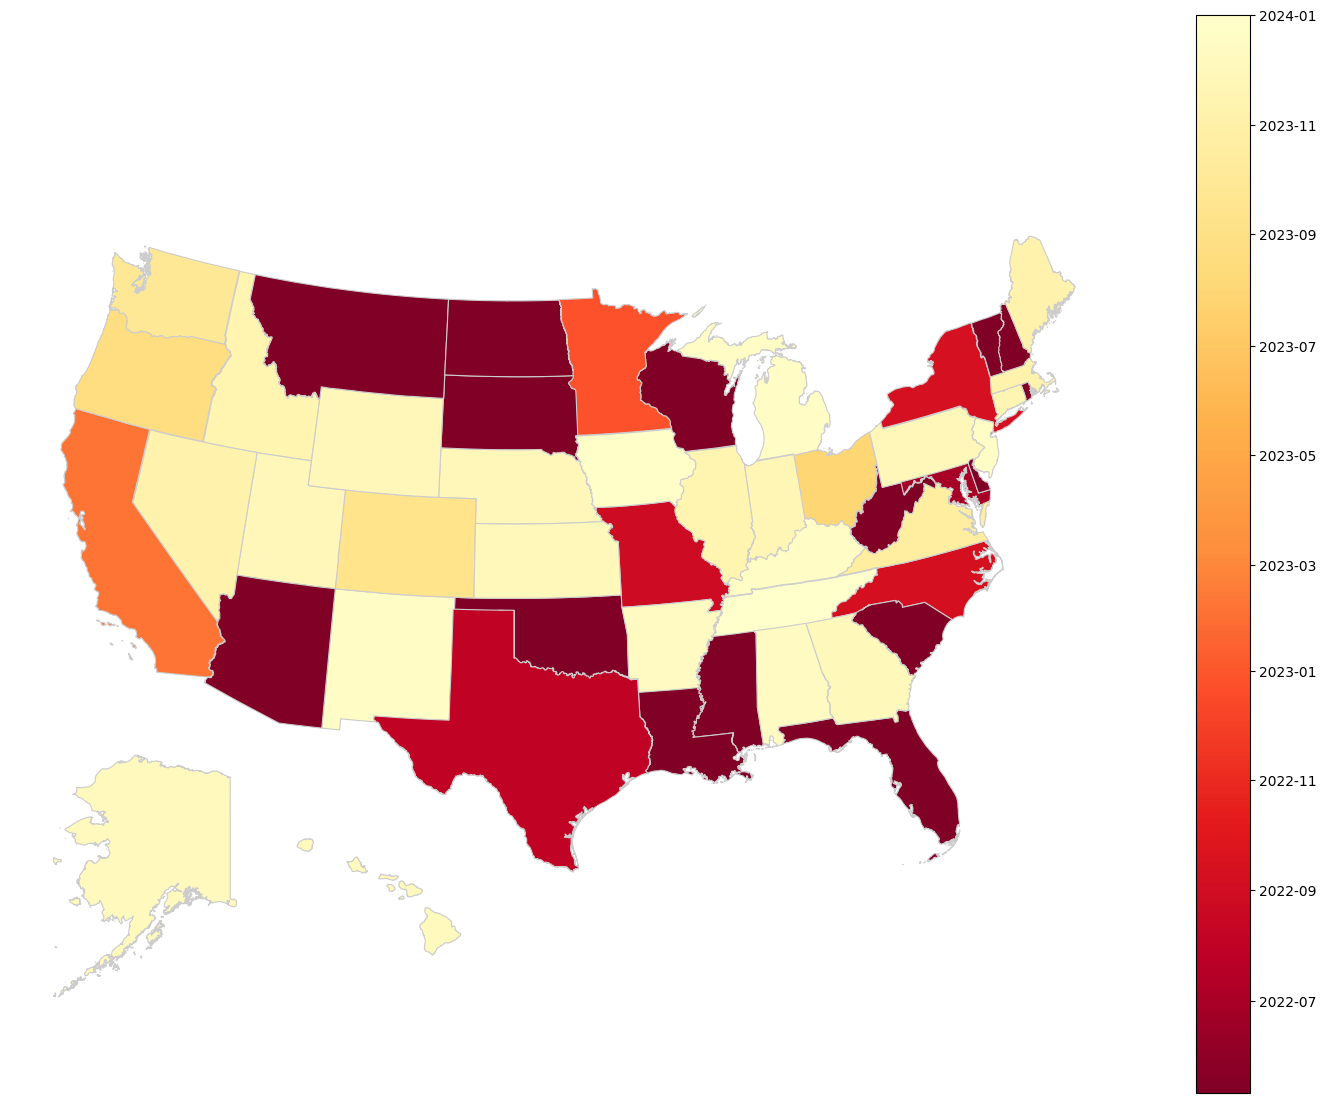

In [8]:
ba286_samples['STUSPS'] = ba286_samples['geo_loc_region'].apply(state_to_abbrev)
date_third_sample = outbreak_tools.first_date(ba286_samples, by='STUSPS')

date_third_sample = pd.to_datetime(date_third_sample).apply(matplotlib.dates.date2num)
datecolors = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=mcolors.Normalize(vmin=date_third_sample.min(), vmax=date_third_sample.max(), clip=True))
fig, ax = USmap(date_third_sample, datecolors)
loc = matplotlib.dates.AutoDateLocator()
fig.colorbar(datecolors, ax=ax, ticks=loc, format=matplotlib.dates.AutoDateFormatter(loc))
print(date_third_sample.head())

#### prevalence of G at bp site 7842 over time in samples from one collection site

In [9]:
g7842_samples = outbreak_data.get_wastewater_samples_by_mutation(site=7842, alt_base='G', min_prevalence=0.01)
g7842_samples = outbreak_data.get_wastewater_metadata(g7842_samples)

GET https://dev.outbreak.info/wastewater_variants/query?q=frequency:>=0.01 AND site:7842 AND alt_base:G&fetch_all=true
GET https://dev.outbreak.info/wastewater_variants/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABoI0BZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=true&page=0&fetch_all=true
GET https://dev.outbreak.info/wastewater_variants/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABoI0BZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=true&page=1&fetch_all=true
POST https://dev.outbreak.info/wastewater_metadata/query


collection_date  mutation           
2023-12-04       7842 AND alt_base:G    0.183354
2023-11-27       7842 AND alt_base:G    0.158220
2023-11-06       7842 AND alt_base:G    0.053362
2023-11-08       7842 AND alt_base:G    0.011680
2023-12-17       7842 AND alt_base:G    0.592946
Name: prevalence, dtype: float64


/tmp/ipykernel_46844/1544639088.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  csite = g7842_samples['collection_site_id'][6]


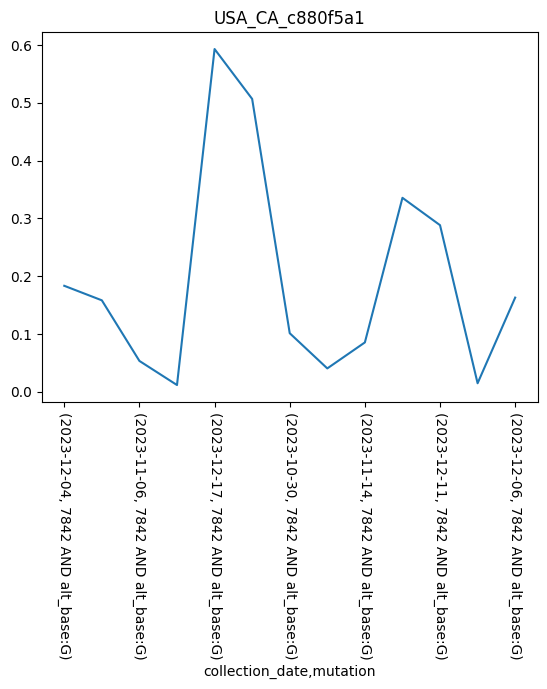

In [10]:
csite = g7842_samples['collection_site_id'][6]
freqs = g7842_samples[g7842_samples['collection_site_id'] == csite]['prevalence']
freqs.plot(rot=-90)
plt.title(csite)
print(freqs.head())

#### weighted average prevalence of G at bp site 7842 over time across US samples

In [11]:
startdate, enddate = "2023-09-01", "2023-12-31"
usa_samples = outbreak_data.get_wastewater_samples(country='USA', date_range=[startdate, enddate])
print(usa_samples.head())

GET https://dev.outbreak.info/wastewater_metadata/query?q=geo_loc_country:USA AND collection_date:[2023-09-01 TO 2023-12-31] AND demix_success:true&fetch_all=true
GET https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABoNFxZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=true&page=0&fetch_all=true
GET https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABoNFxZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=true&page=1&fetch_all=true
GET https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABoNFxZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=true&page=2&fetch_all=true
GET https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABoNFxZHV0dfbkk

                                               7842G
(2023-08-31 00:00:00, 2023-09-03 00:00:00]  0.000000
(2023-09-03 00:00:00, 2023-09-06 00:00:00]  0.000576
(2023-09-06 00:00:00, 2023-09-09 00:00:00]  0.000000
(2023-09-09 00:00:00, 2023-09-12 00:00:00]  0.000000
(2023-09-12 00:00:00, 2023-09-15 00:00:00]  0.000000


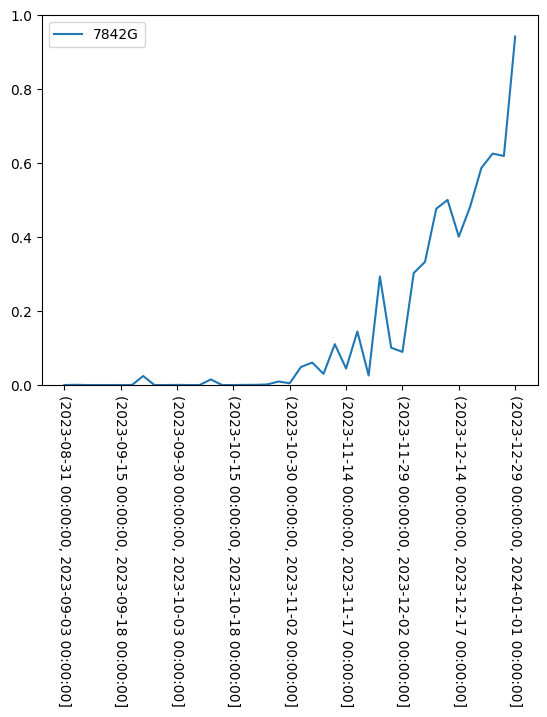

In [12]:
usa_samples_g7842 = pd.merge(usa_samples.reset_index(names=usa_samples.index.names), g7842_samples[['sra_accession', 'prevalence']], on='sra_accession', how='left').set_index(usa_samples.index.names).fillna(0)
usa_samples_g7842.index = pd.MultiIndex.from_arrays(arrays=[usa_samples_g7842.index, usa_samples_g7842.index], names=['collection_date', 'mutation'])
usa_samples_g7842 = outbreak_tools.const_idx(usa_samples_g7842, '7842G', 1)
freqs = outbreak_tools.datebin_and_agg(usa_samples_g7842, weights=outbreak_tools.get_ww_weights(usa_samples_g7842), freq='3D', norm=False)
freqs.plot(rot=-90)
plt.ylim(0,1)
print(freqs.head())

#### map of weighted average prevalence of G at bp site 7842 in US states in sept-dec 2023

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


STUSPS                                            
AK      (2023-09-03 00:00:00, 2023-12-29 00:00:00]    0.429411
AL      (2023-09-02 00:00:00, 2023-12-28 00:00:00]    0.262508
AR      (2023-09-01 00:00:00, 2023-12-29 00:00:00]    0.289508
CA      (2023-08-31 00:00:00, 2023-12-29 00:00:00]    0.186426
CO      (2023-08-31 00:00:00, 2023-12-16 00:00:00]    0.000000
Name: 7842G, dtype: float64


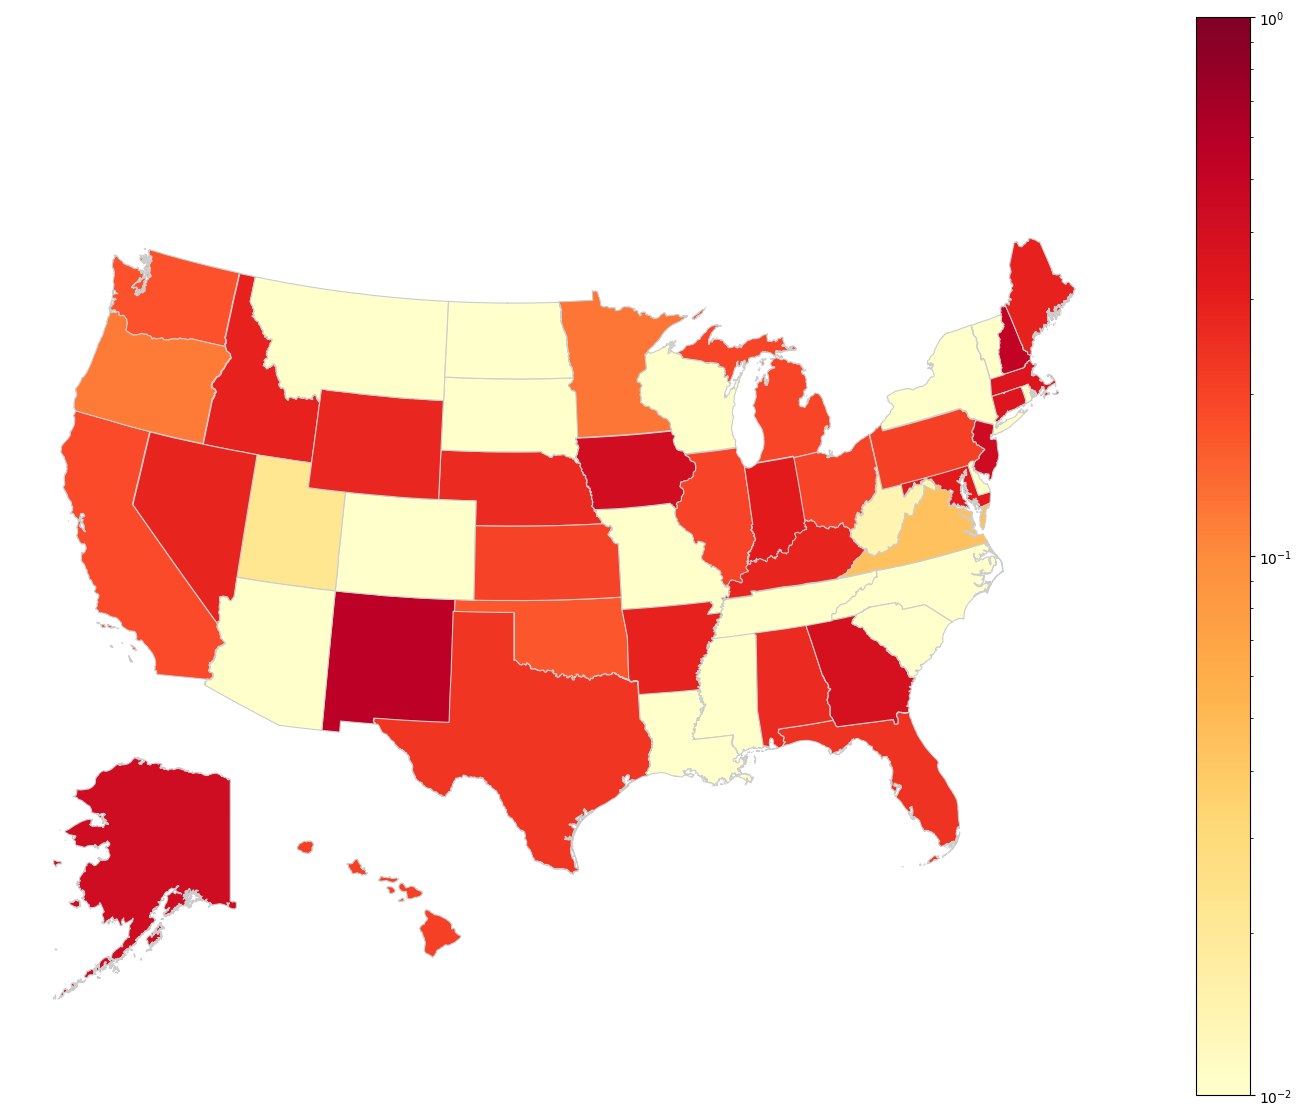

In [13]:
usa_samples_g7842['STUSPS'] = usa_samples_g7842['geo_loc_region'].apply(state_to_abbrev)
colors = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.LogNorm(vmin=1e-2, vmax=1, clip=True))
freqs = usa_samples_g7842.groupby('STUSPS').apply(
        lambda x: outbreak_tools.datebin_and_agg(x, weights=outbreak_tools.get_ww_weights(x), freq=None, norm=False), 
    include_groups=False )['7842G']
fig, ax = USmap(freqs, colors)
fig.colorbar(colors, ax=ax)
print(freqs.head())

#### animated weekly map of HV.1* prevalence across US states

In [14]:
usa_samples = outbreak_data.get_wastewater_lineages(usa_samples)
print(usa_samples.head())

POST https://dev.outbreak.info/wastewater_demix/query
                        collection_site_id  demix_success geo_loc_country  \
collection_date lineage                                                     
2023-09-03      EG.10      USA_AR_7fdff14c           True             USA   
                EG.10.1    USA_AR_7fdff14c           True             USA   
                EG.14      USA_AR_7fdff14c           True             USA   
                EG.2       USA_AR_7fdff14c           True             USA   
                EG.2.3     USA_AR_7fdff14c           True             USA   

                        geo_loc_region sra_accession  viral_load  \
collection_date lineage                                            
2023-09-03      EG.10         Arkansas   SRR26099343         NaN   
                EG.10.1       Arkansas   SRR26099343         NaN   
                EG.14         Arkansas   SRR26099343         NaN   
                EG.2          Arkansas   SRR26099343         NaN  

In [15]:
ww_abd = usa_samples.groupby('geo_loc_region') \
            .apply(lambda x: outbreak_tools.datebin_and_agg(x, weights=outbreak_tools.get_ww_weights(x), startdate=startdate, enddate=enddate, freq='7D'), include_groups=False).fillna(0)
ww_abd.index = ww_abd.index.set_names(['geo_loc_region', 'date_bin'])
print(ww_abd.iloc[:5,:5])

                                                                B.1  \
geo_loc_region date_bin                                               
Alabama        (2023-08-31 00:00:00, 2023-09-07 00:00:00]  0.000000   
               (2023-09-07 00:00:00, 2023-09-14 00:00:00]  0.000745   
               (2023-09-14 00:00:00, 2023-09-21 00:00:00]  0.000000   
               (2023-09-21 00:00:00, 2023-09-28 00:00:00]  0.000000   
               (2023-09-28 00:00:00, 2023-10-05 00:00:00]  0.000000   

                                                              B.1.1.431  \
geo_loc_region date_bin                                                   
Alabama        (2023-08-31 00:00:00, 2023-09-07 00:00:00]  0.000000e+00   
               (2023-09-07 00:00:00, 2023-09-14 00:00:00]  3.385413e-07   
               (2023-09-14 00:00:00, 2023-09-21 00:00:00]  0.000000e+00   
               (2023-09-21 00:00:00, 2023-09-28 00:00:00]  0.000000e+00   
               (2023-09-28 00:00:00, 2023-10-05 00:0

In [17]:
tree = outbreak_tools.get_tree()
lineage_key = outbreak_clustering.get_lineage_key(tree)

In [18]:
lin = 'HV.1'
data = ww_abd.apply(lambda x: outbreak_clustering.get_agg_prevalence(lineage_key[lin], x), axis=1).rename('prevalence').to_frame().reset_index()
print(data.head())

  geo_loc_region                                    date_bin  prevalence
0        Alabama  (2023-08-31 00:00:00, 2023-09-07 00:00:00]    0.000000
1        Alabama  (2023-09-07 00:00:00, 2023-09-14 00:00:00]    0.000000
2        Alabama  (2023-09-14 00:00:00, 2023-09-21 00:00:00]    0.000181
3        Alabama  (2023-09-21 00:00:00, 2023-09-28 00:00:00]    0.000000
4        Alabama  (2023-09-28 00:00:00, 2023-10-05 00:00:00]    0.000000


/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


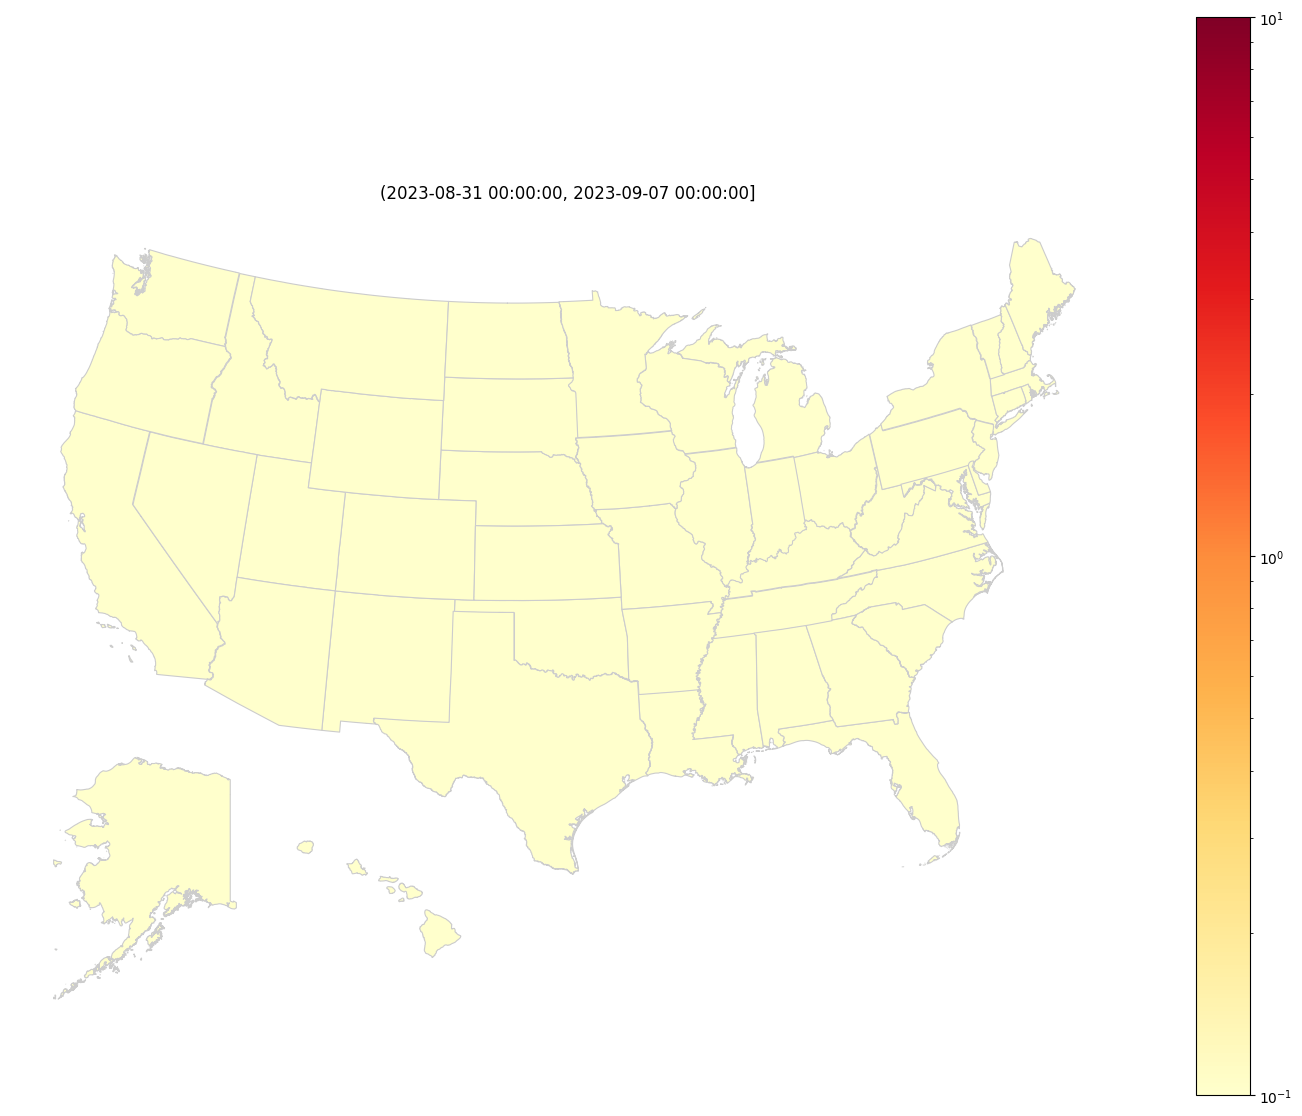

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


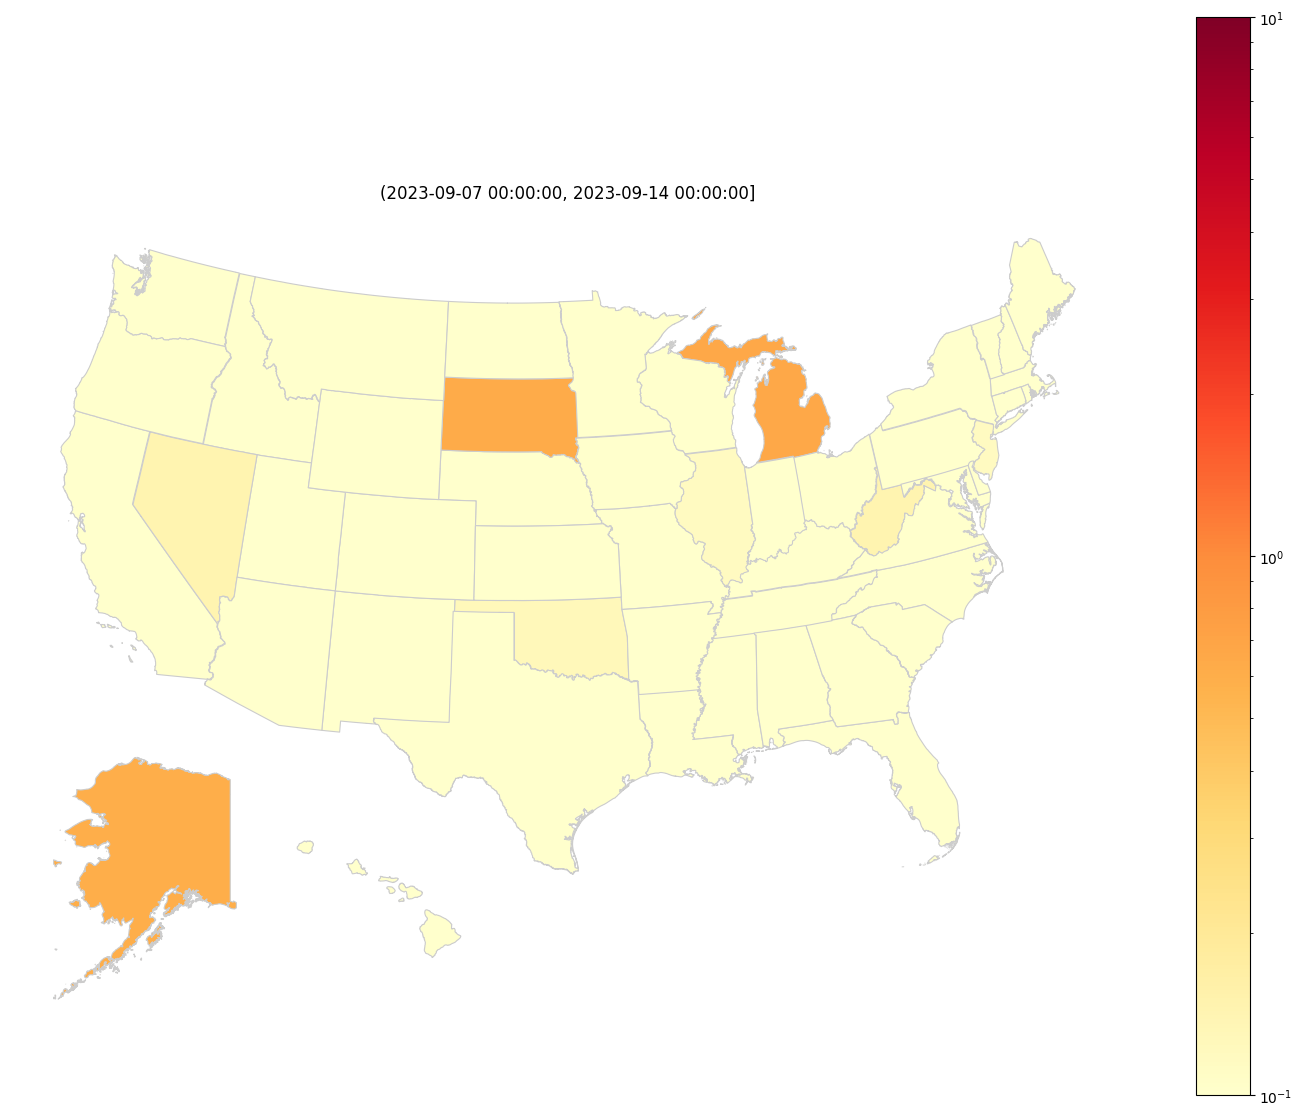

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


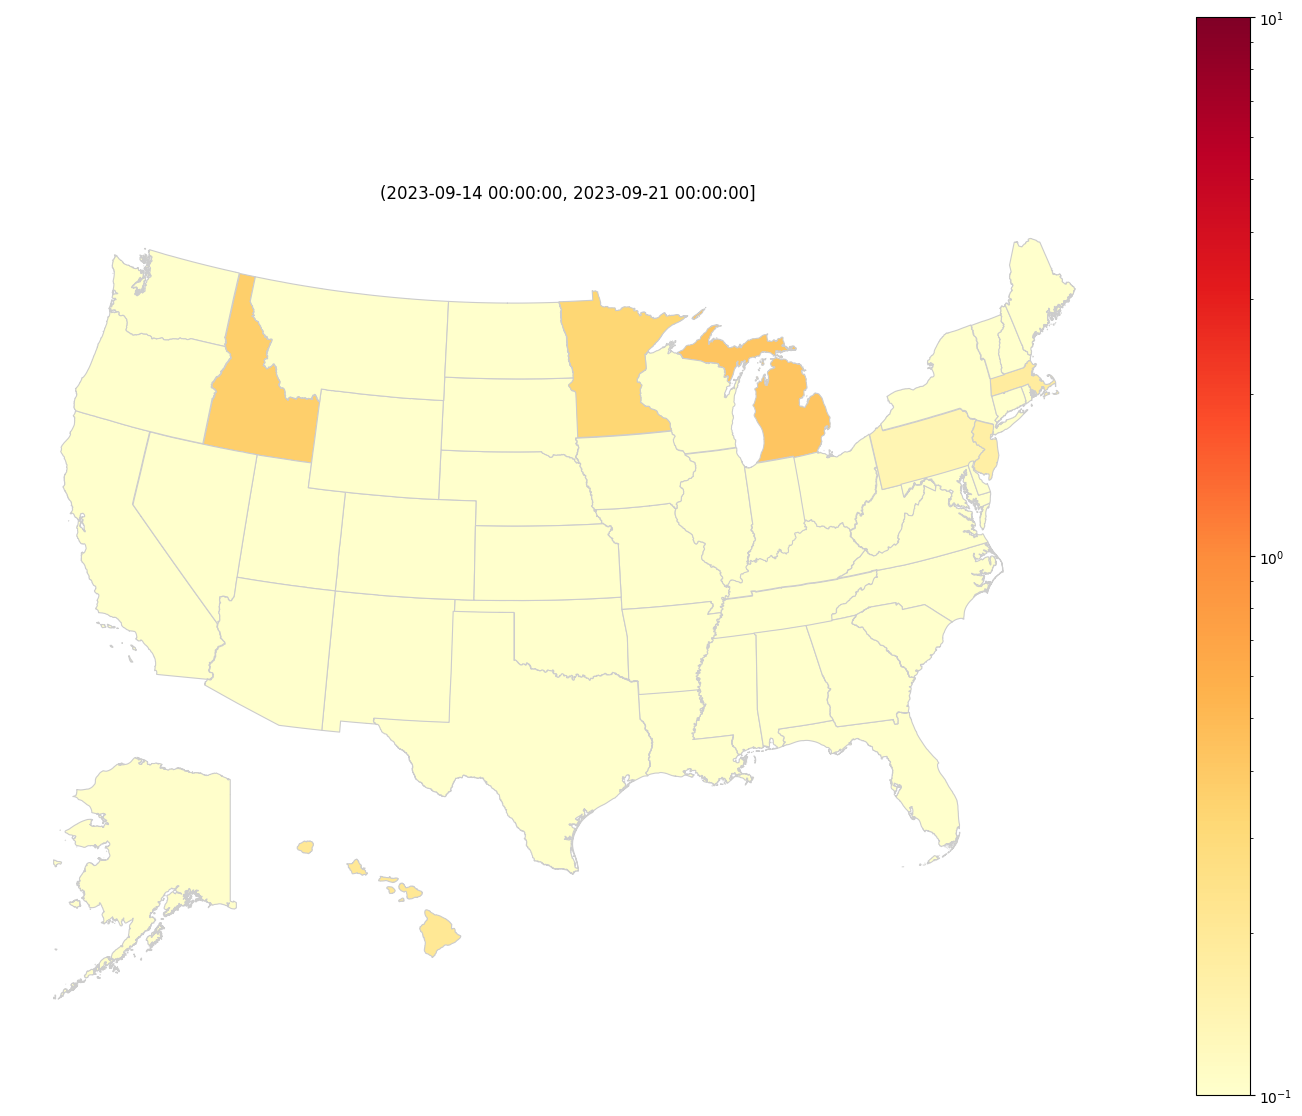

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


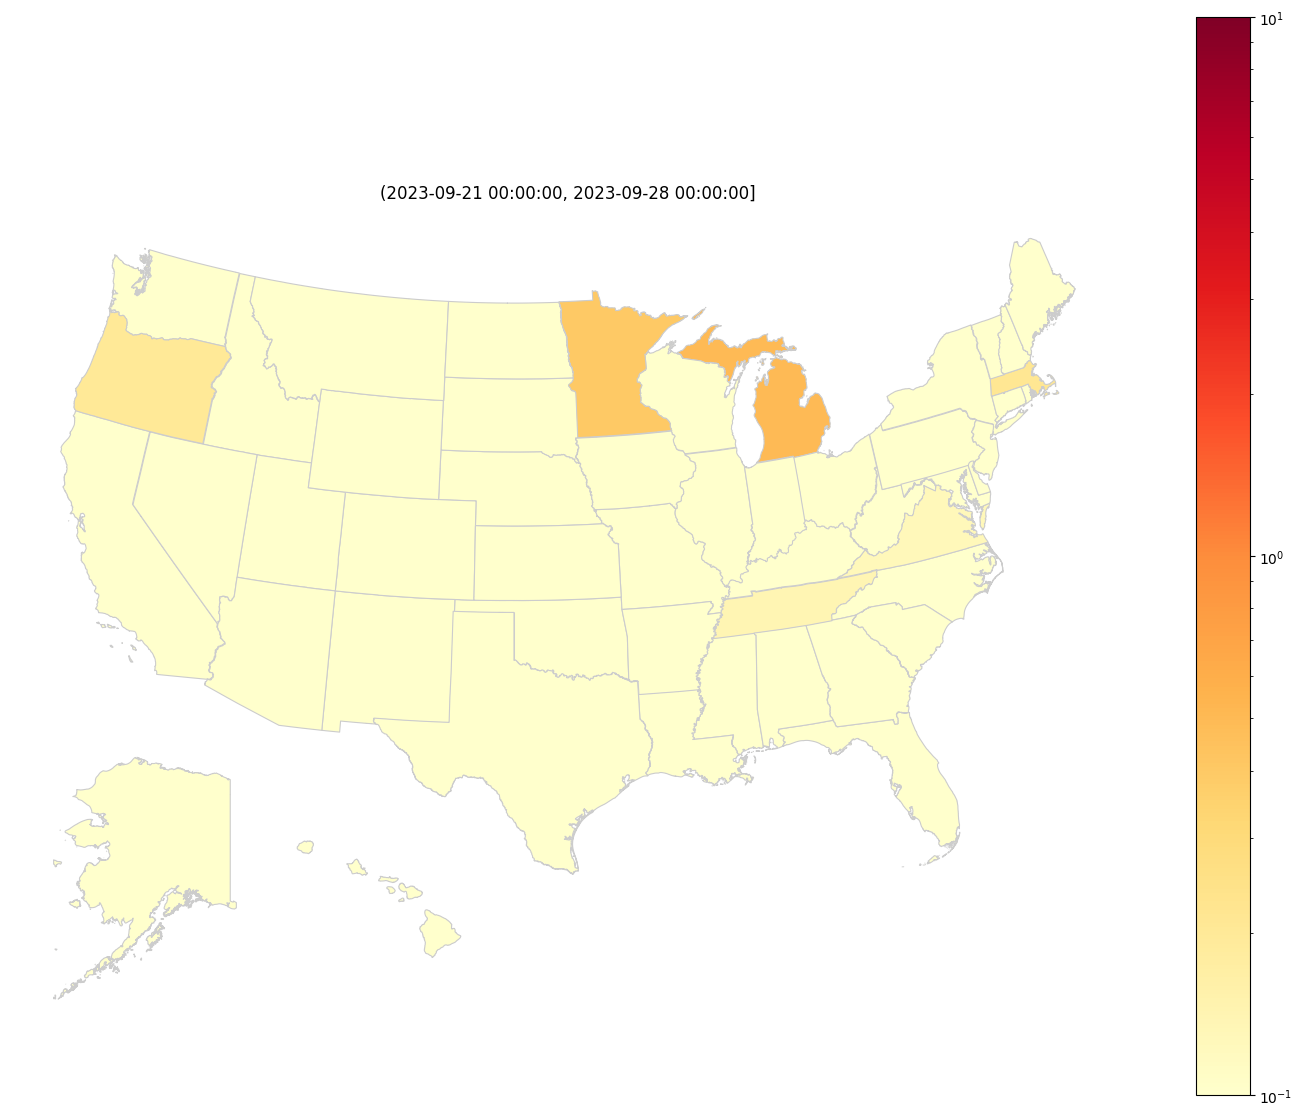

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


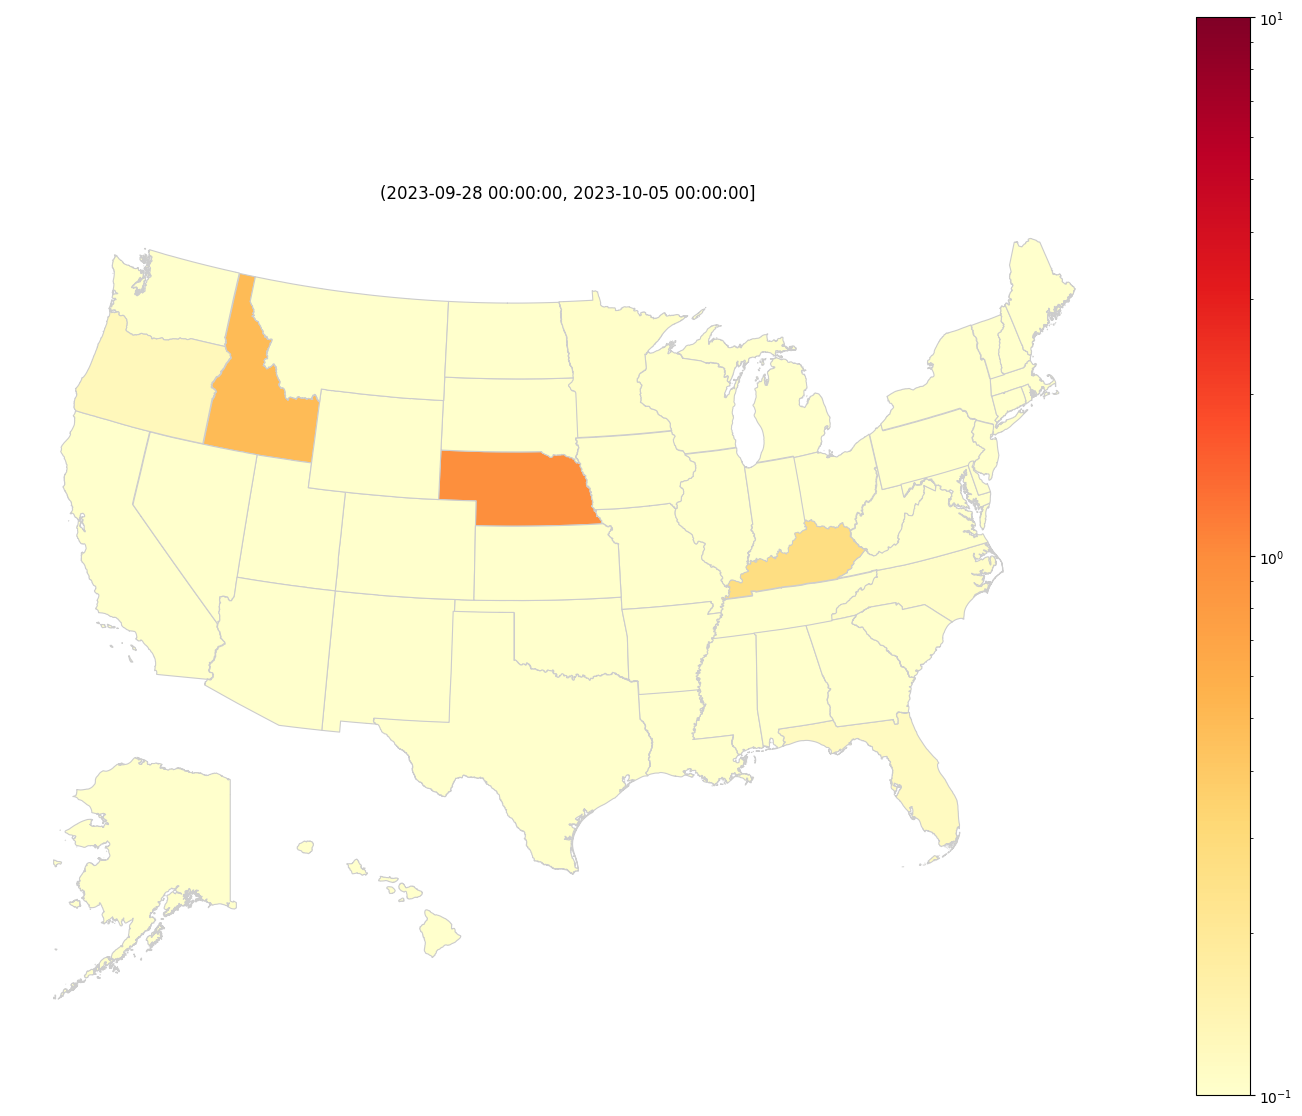

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


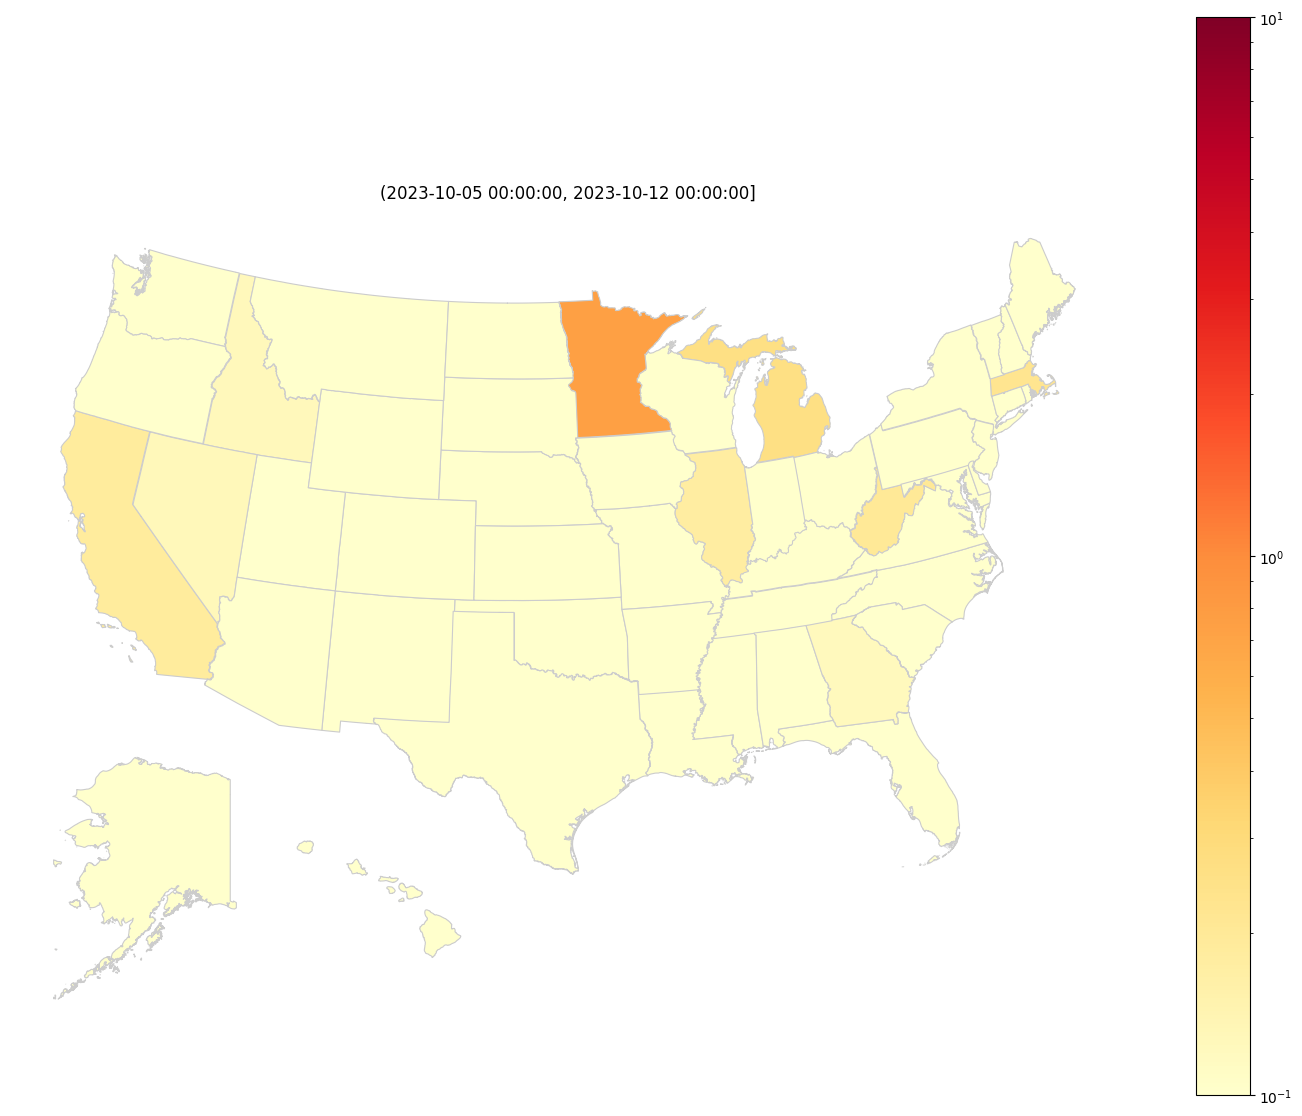

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


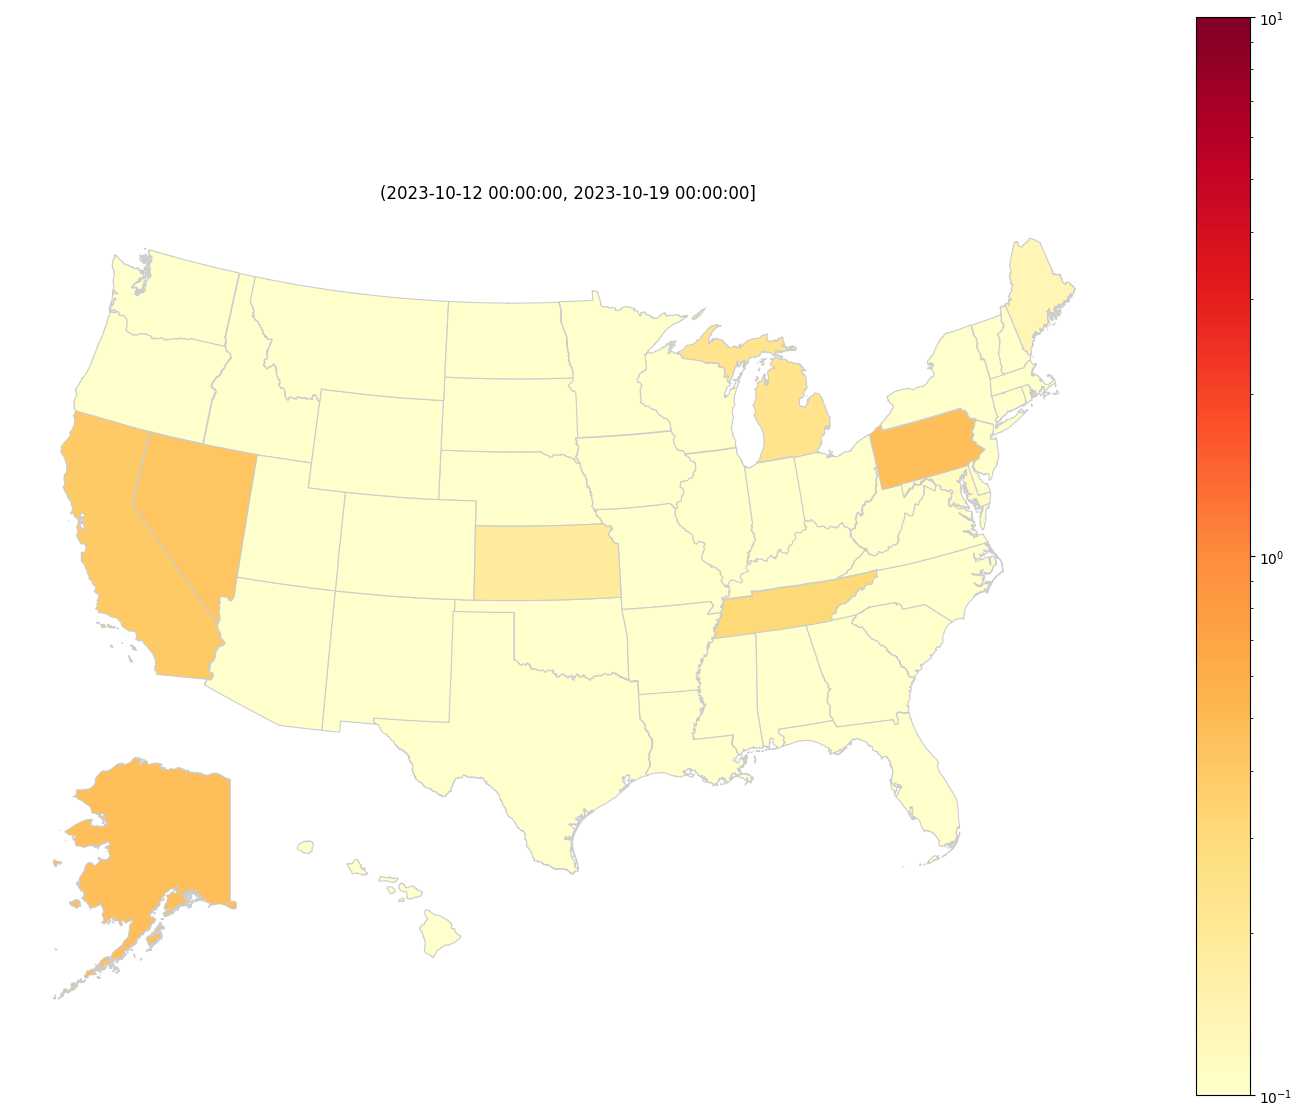

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


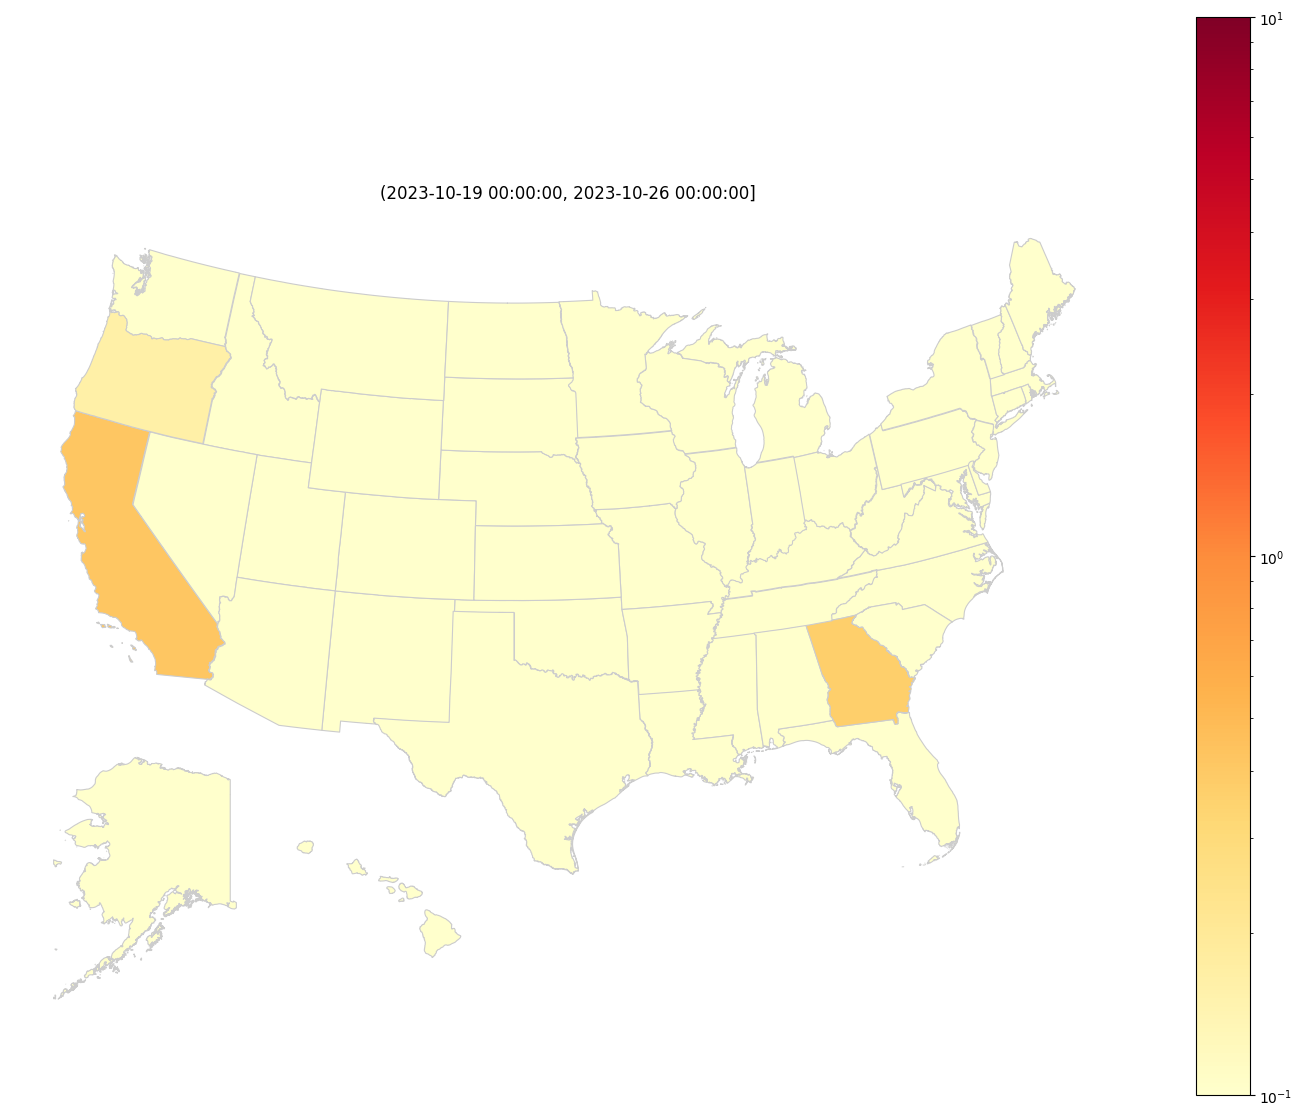

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


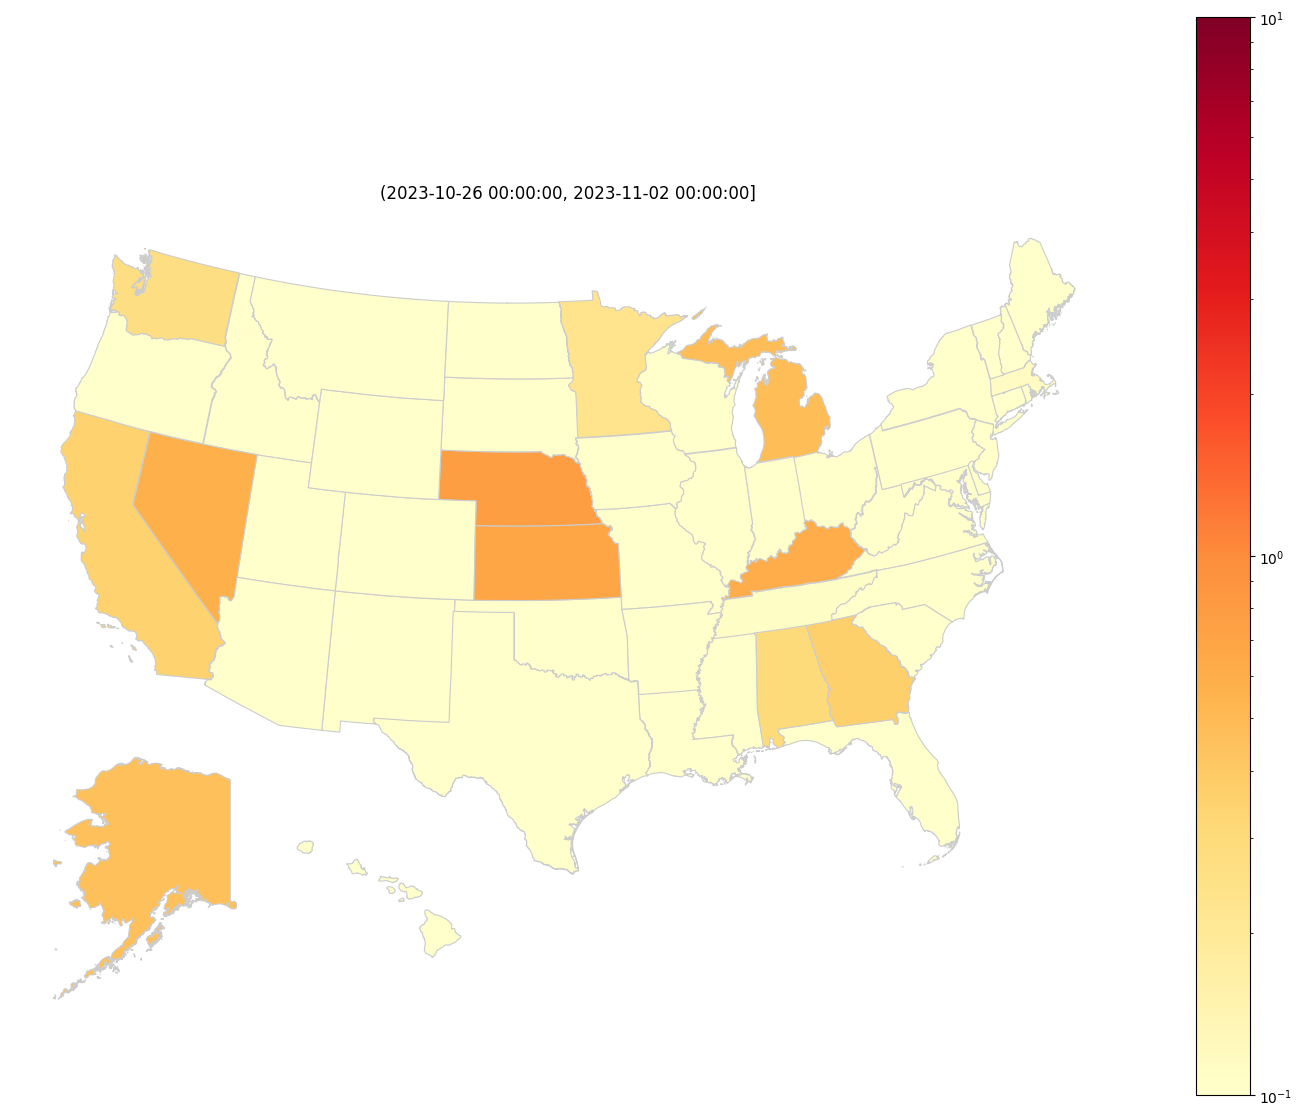

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


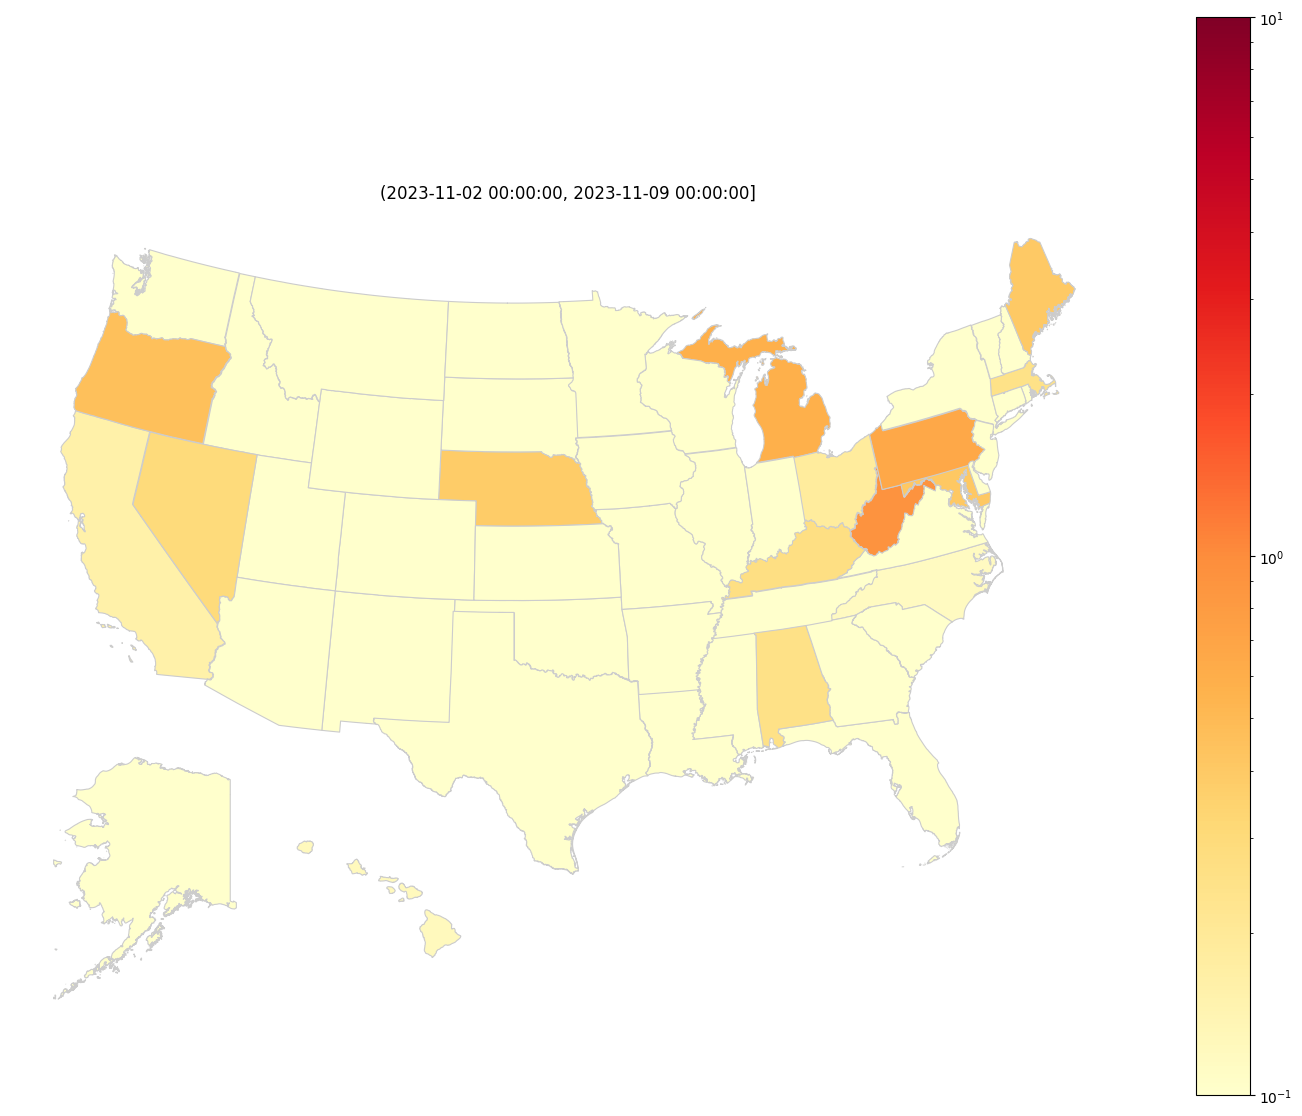

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


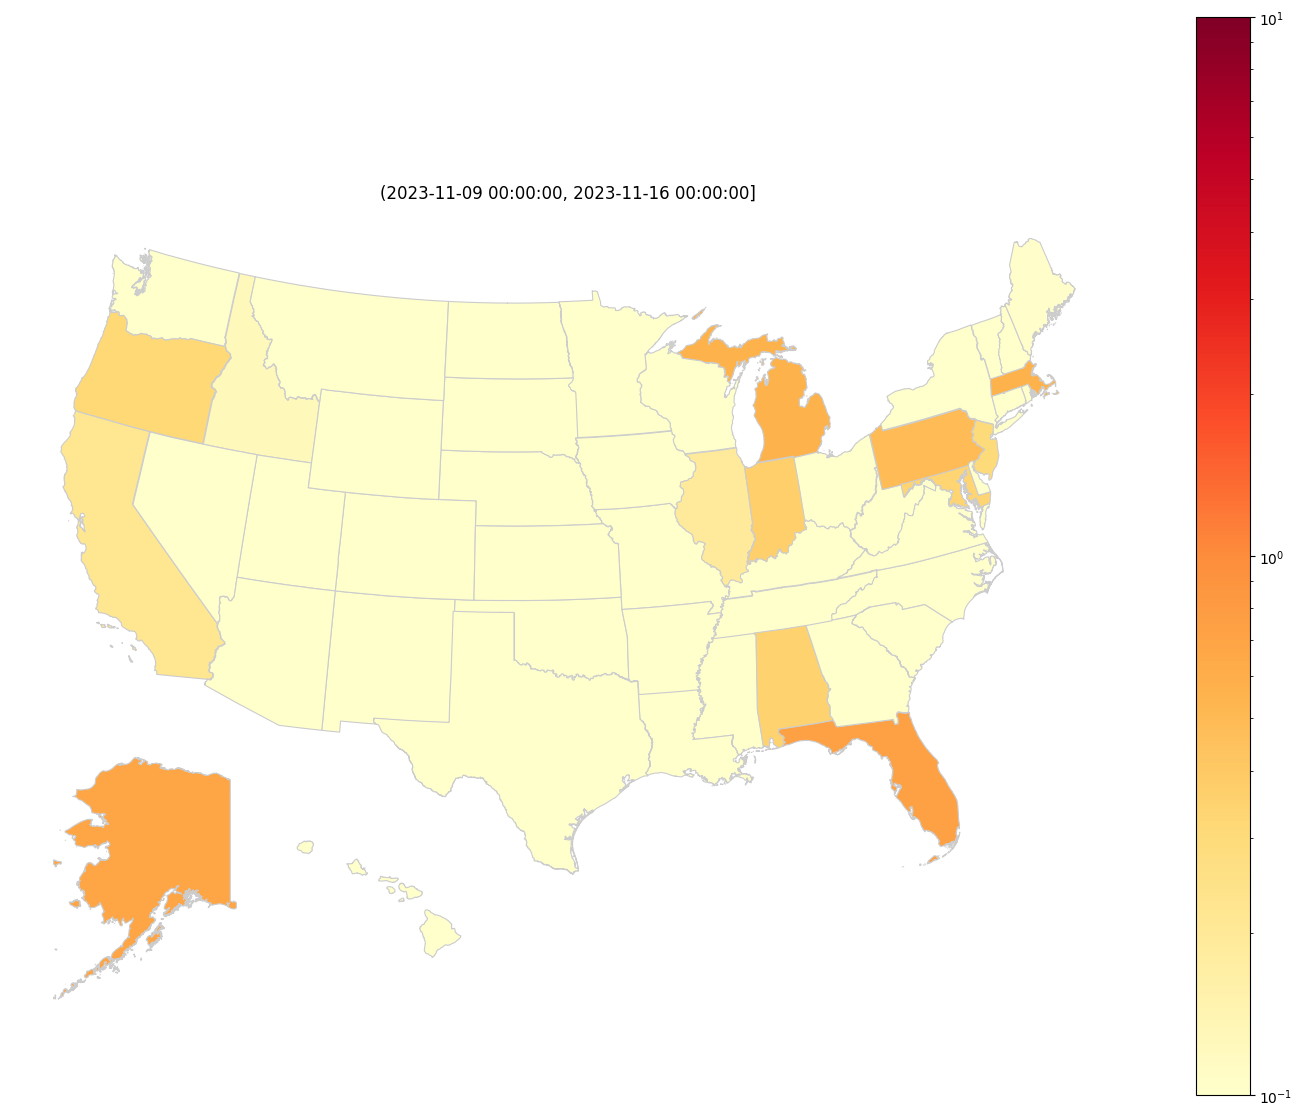

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


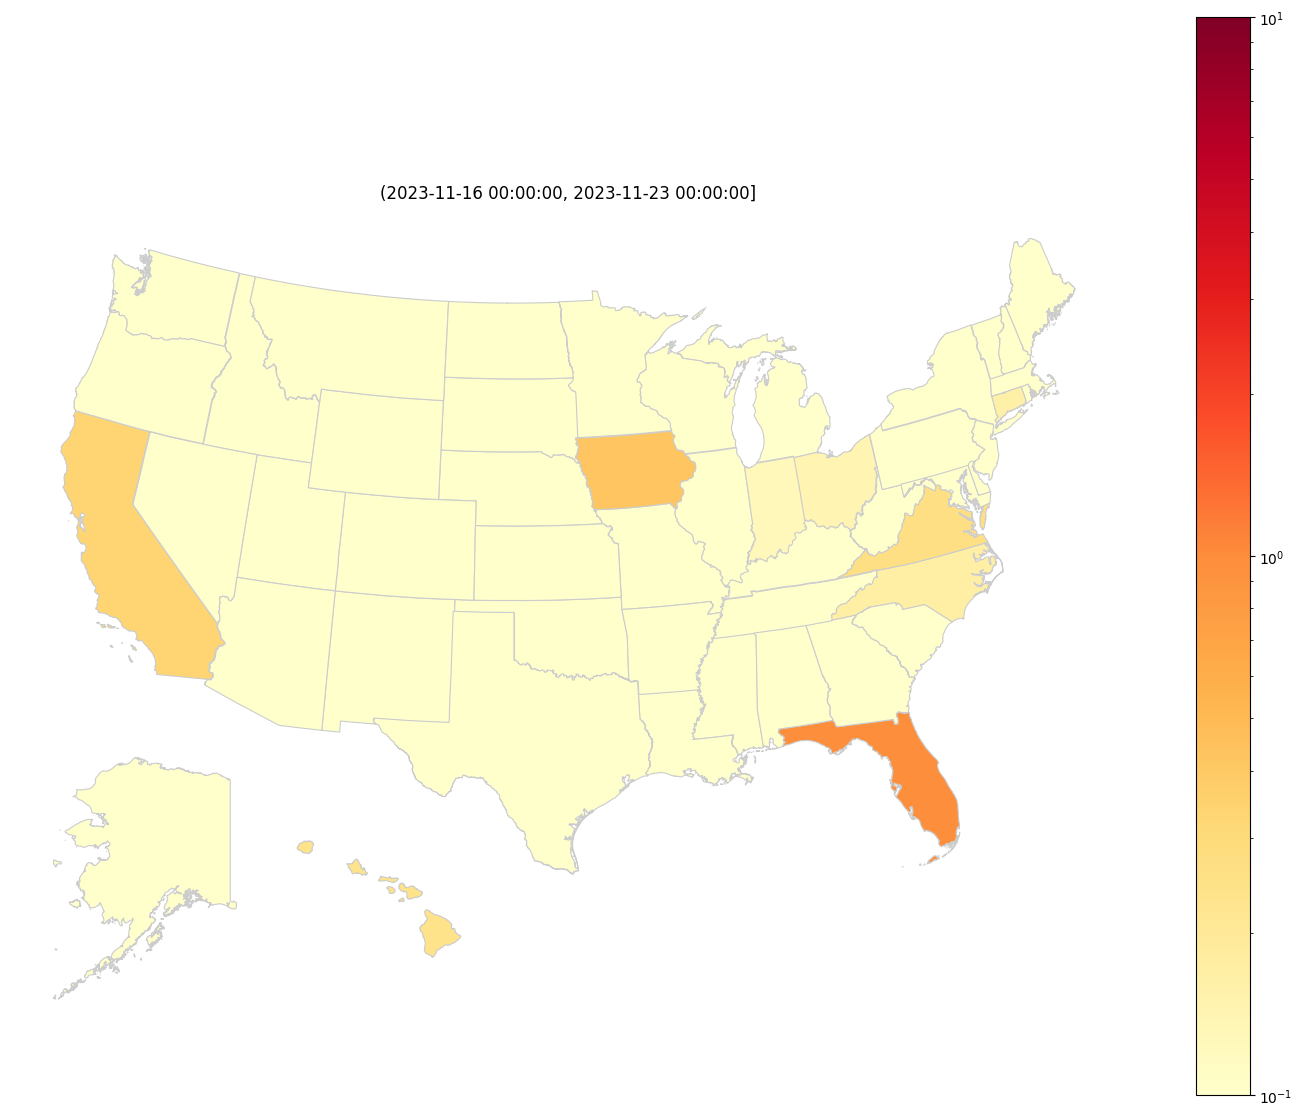

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


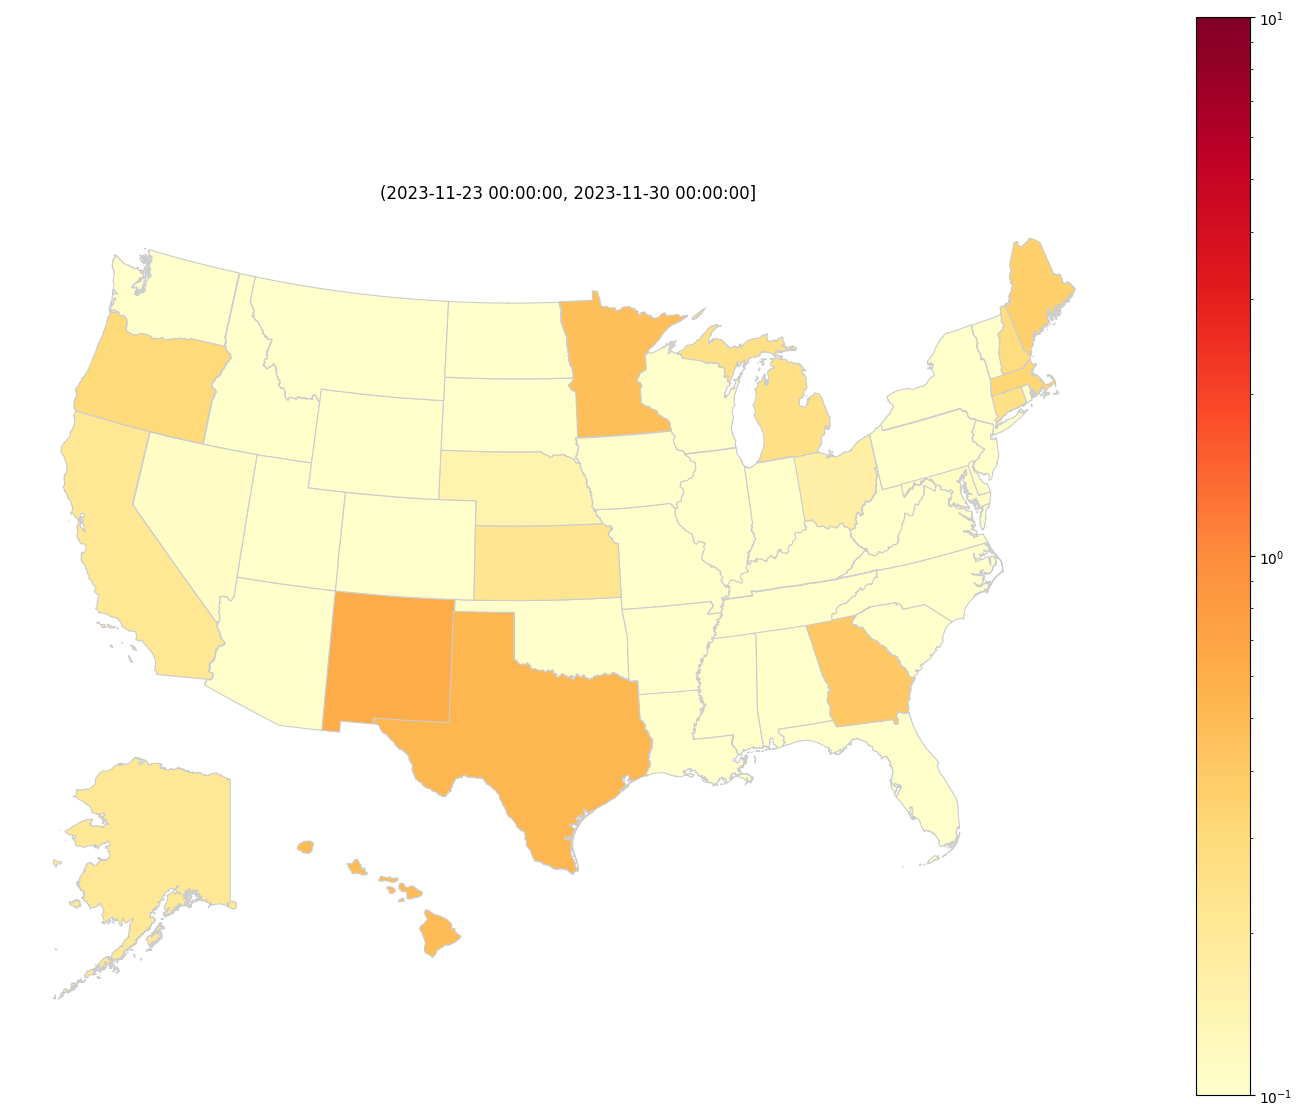

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


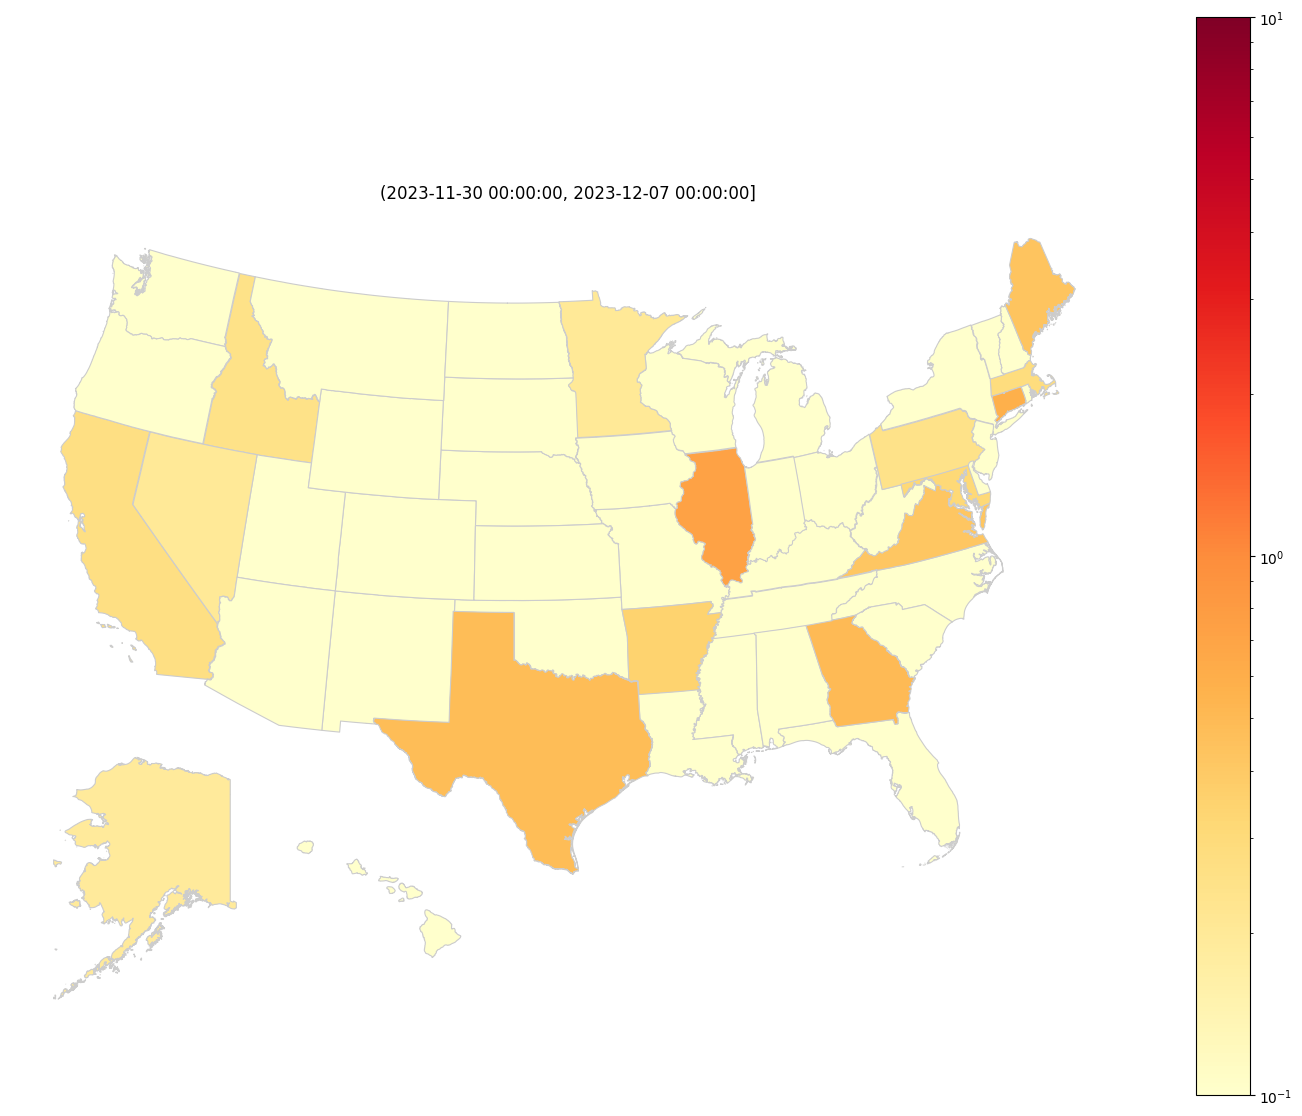

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


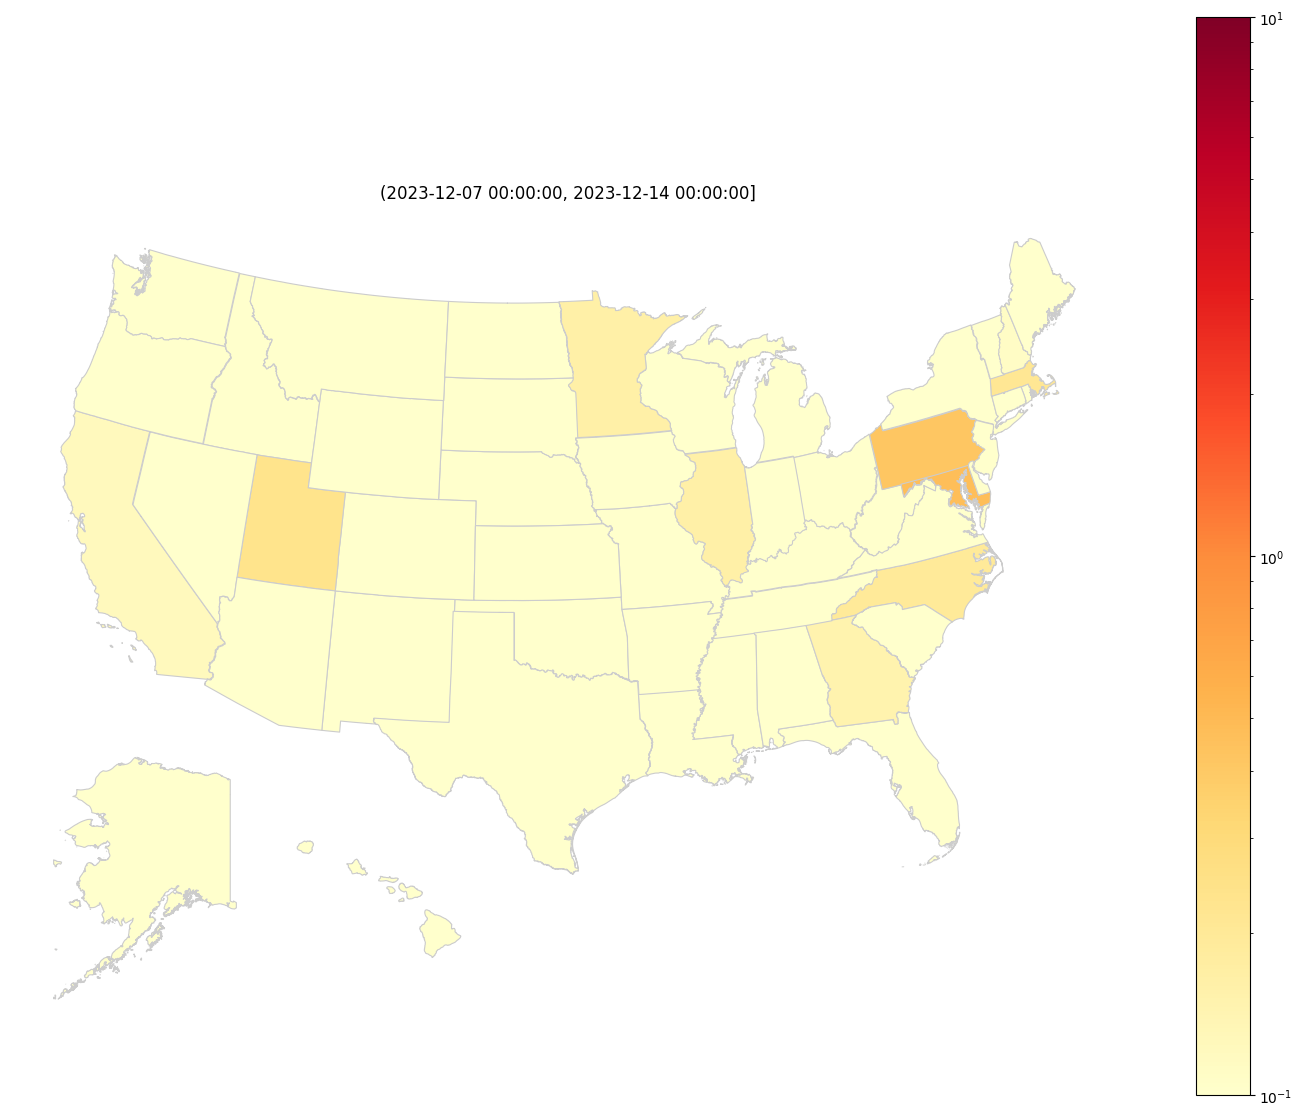

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


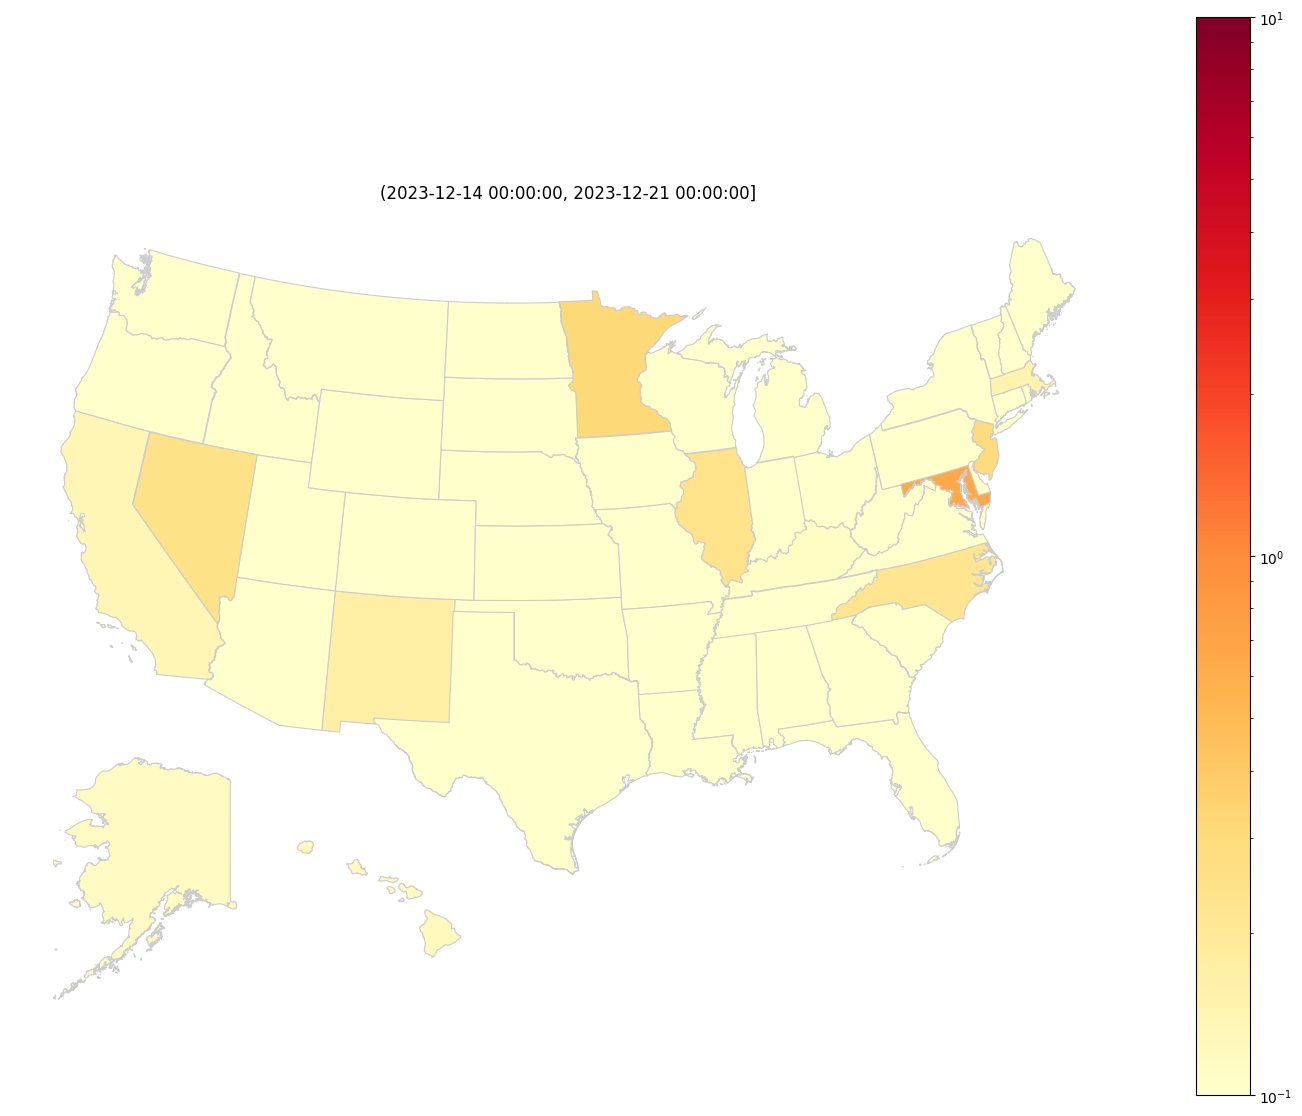

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


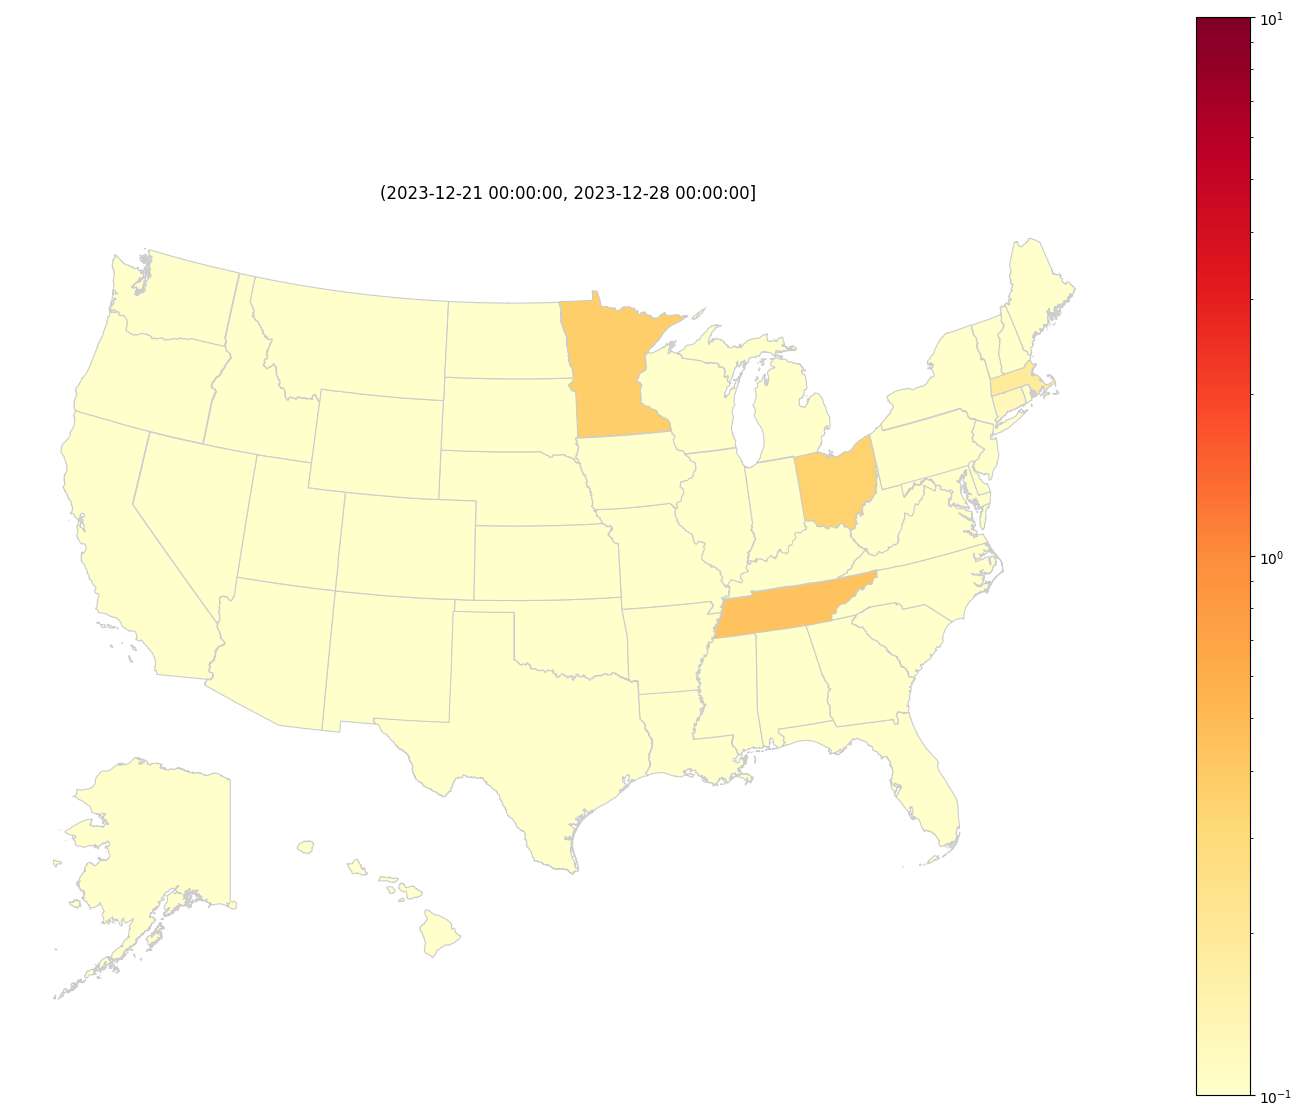

/tmp/ipykernel_46844/3674656150.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [19]:
data['STUSPS'] = data['geo_loc_region'].apply(state_to_abbrev)
colors = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.LogNorm(vmin=1e-1, vmax=10, clip=True))
png_list = []
for datebin in np.sort(data['date_bin'].unique()):
    d = data[data['date_bin'] == datebin].set_index('STUSPS')['prevalence']
    fig, ax = USmap(d, colors)
    fig.colorbar(colors, ax=ax)
    ax.set_title(datebin)
    plt.show()
    filename = f'map_frames/{lin}_map_wastewater_{datebin}.png'
    fig.savefig(filename)
    png_list.append(filename)

with imageio.get_writer(f'map_gifs/{lin}_ww_map.gif', mode='I', fps=2, loop=False) as writer:
    for filename in png_list:
        image = imageio.imread(filename)
        writer.append_data(image)